In [69]:
import os
from functools import partial
import torch
import numpy as np
import matplotlib.pyplot as plt
import pyro
import pyro.distributions as dist
from pyro.nn import PyroSample, PyroModule
from pyro.infer.autoguide import AutoDiagonalNormal
from pyro.infer import SVI, Trace_ELBO
import torch.nn as nn

verbose = False
NUM_TRAIN = 150
NUM_TRAIN_REPEATS = 1
NUM_EPOCHS = 5_000
RAW_SAMPLES = 20
NUM_EPS_SAMPLES = 200
EPS = 2
MU_INIT = 0.0
STD_INIT = 1.

class BNN(PyroModule):
    def __init__(self, input_dim=2, hidden_dim=50):
        super().__init__()
        self.linear1 = PyroModule[nn.Linear](input_dim, hidden_dim) # Input to hidden layer
        self.linear2 = PyroModule[nn.Linear](hidden_dim, 1) # Hidden to output layer
        self.activation = nn.ReLU()        

        self.linear1.weight = PyroSample(dist.Normal(0., STD_INIT).expand([hidden_dim, input_dim]).to_event(2))
        self.linear1.bias = PyroSample(dist.Normal(0., STD_INIT).expand([hidden_dim]).to_event(1))
        self.linear2.weight = PyroSample(dist.Normal(0., STD_INIT).expand([1, hidden_dim]).to_event(2))
        self.linear2.bias = PyroSample(dist.Normal(0., STD_INIT).expand([1]).to_event(1))

    def forward(self, x, y=None):
        x = self.activation(self.linear1(x))
        mean = self.linear2(x).squeeze(-1)
        # sigma = pyro.sample("sigma", dist.Uniform(0., STD_INIT))
        sigma = pyro.sample("sigma", dist.LogNormal(0., STD_INIT))
        with pyro.plate("data", x.shape[0]):
            obs = pyro.sample("obs", dist.Normal(mean, sigma), obs=y)
        return mean

# Define Noisy Objective Function
def expensive_function(x):
    """The 1st column of x gives the nominal inputs, 2nd column gives the noise"""
    noised_x = torch.sum(x, dim=1)
    noised_value = torch.where(noised_x >= 0, torch.sqrt(noised_x), -noised_x)
    # Add some additional noise we want to capture via Bayesian layers
    std = 0.1
    extra_noise = torch.normal(mean=torch.zeros(x.shape[0]), std=std)
    return noised_value + extra_noise

In [72]:
# Generate Training Data
train_x = torch.empty(NUM_TRAIN, 2)
train_x[:,0].uniform_(-2,2)
train_x[:,1].uniform_(-EPS, EPS)
train_x = train_x.repeat((NUM_TRAIN_REPEATS,1)) # Generate repeats of the initial points to help learn variance
train_y  = expensive_function(train_x)
    
model = BNN(input_dim=2, hidden_dim=50)
# guide = AutoDiagonalNormal(model)
guide = pyro.infer.autoguide.AutoMultivariateNormal(model)
adam = pyro.optim.Adam({"lr": 0.001})
svi = SVI(model, guide, adam, loss=Trace_ELBO())

pyro.clear_param_store()
for epoch in range(NUM_EPOCHS):
    # calculate the loss and take a gradient step
    loss = svi.step(train_x, train_y)
    if epoch % (int(NUM_EPOCHS/10)) == 0:
        print("[iteration %04d] loss: %.4f" % (j + 1, loss / len(train_x)))

[iteration 5000] loss: 4.4557
[iteration 5000] loss: 3.3034
[iteration 5000] loss: 2.4571
[iteration 5000] loss: 3.6583
[iteration 5000] loss: 3.0725
[iteration 5000] loss: 1.8916
[iteration 5000] loss: 2.2349
[iteration 5000] loss: 2.0258
[iteration 5000] loss: 1.7714
[iteration 5000] loss: 1.8659


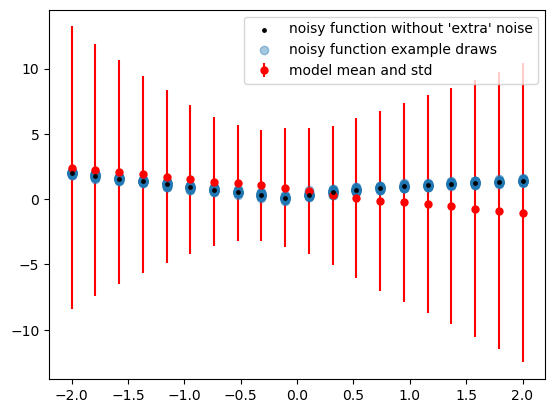

In [73]:
def function_without_extra_noise(x):
    noised_x = torch.sum(x, dim=1)
    noised_value = torch.where(noised_x >= 0, torch.sqrt(noised_x), -noised_x)
    return noised_value 

x_repeats = 30
train_x = torch.empty(20, 2)
# train_x[:,0].uniform_(-2,2)
train_x[:,0] = torch.linspace(-2,2,train_x.shape[0])
# train_x[:,1].uniform_(-EPS, EPS)
train_x[:,1] = torch.zeros(train_x.shape[0]) 

with torch.no_grad():
    mu_pred_all = torch.stack([model(train_x) for _ in range(x_repeats)])
    std = mu_pred_all.std(axis=0).squeeze()
    plt.errorbar(train_x[:,0], mu_pred_all.mean(axis=0).squeeze(), yerr=std, c='r', fmt='o', markersize=5, label='model mean and std', zorder=1)
    
    plt.scatter(train_x[:,0], function_without_extra_noise(train_x), c='k', label="noisy function without 'extra' noise", alpha=1, s=6, zorder=2)
    train_x = train_x.repeat((x_repeats,1)) 
    train_y  = expensive_function(train_x)
    plt.scatter(train_x[:,0], train_y, label='noisy function example draws', alpha=0.4)
    plt.legend()
    plt.show()